In [51]:
import pandas as pd
import warnings

# Optional: hide FutureWarnings during exploration
warnings.simplefilter(action='ignore', category=FutureWarning)

# ===== Step 1. Load the Excel file =====
file_path = r"C:\Users\Ashwin\loop ai hackathon\health_markers_dataset.csv"
df = pd.read_csv(file_path)

print("Initial shape:", df.shape)
print("\nColumns before cleaning:\n", df.columns.tolist())
print("\nPreview:\n", df.head())

# ===== Step 2. Standardize column names =====
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace('[^a-z0-9]+', '_', regex=True)
)

# ===== Step 3. Remove duplicates =====
df.drop_duplicates(inplace=True)

# ===== Step 4. Drop rows with too many missing values =====
df.dropna(thresh=int(0.5 * len(df.columns)), inplace=True)

# ===== Step 5. Fill remaining missing values (future-proof syntax) =====
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
        df[col] = df[col].fillna(mode_val)

# ===== Step 6. Normalize categorical labels (example column: 'status') =====
if 'status' in df.columns:
    df['status'] = (
        df['status']
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            'fit': 'Fit',
            'healthy': 'Fit',
            'disease': 'Disease',
            'ill': 'Disease'
        })
    )

# ===== Step 7. Clip numeric outliers to 1st–99th percentile =====
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    q1, q99 = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q1, q99)

# ===== Step 8. Save cleaned data =====
cleaned_path = "blood_tests_cleaned.xlsx"
df.to_excel(cleaned_path, index=False)

print("\n✅ Cleaning complete.")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")
print(f"Cleaned file saved as: {cleaned_path}")


Initial shape: (25000, 10)

Columns before cleaning:
 ['Blood_glucose', 'HbA1C', 'Systolic_BP', 'Diastolic_BP', 'LDL', 'HDL', 'Triglycerides', 'Haemoglobin', 'MCV', 'Condition']

Preview:
    Blood_glucose  HbA1C  Systolic_BP  Diastolic_BP     LDL    HDL  \
0         107.38   4.93       109.25         74.10  129.20  52.11   
1         108.65   5.43        92.61         62.02   51.18  44.06   
2         103.95   6.08       122.95         63.01  107.72  52.08   
3          87.33   4.79        91.16         75.81  109.39  46.83   
4         114.42   4.10       122.86         76.11  123.89  52.92   

   Triglycerides  Haemoglobin    MCV Condition  
0          68.84        10.17  61.54    Anemia  
1          78.82        12.29  91.04       Fit  
2         139.58        15.93  81.75       Fit  
3         108.29        15.18  85.51       Fit  
4         123.22        15.33  92.30       Fit  

✅ Cleaning complete.
Rows: 25000 | Columns: 10
Cleaned file saved as: blood_tests_cleaned.xlsx


Shape: (25000, 10)
Columns: ['blood_glucose', 'hba1c', 'systolic_bp', 'diastolic_bp', 'ldl', 'hdl', 'triglycerides', 'haemoglobin', 'mcv', 'condition']

Class distribution:
 condition
Fit                 18000
Diabetes             3052
Hypertension         1757
High_Cholesterol     1323
Anemia                868
Name: count, dtype: int64

✅ Model Performance:
Accuracy: 1.0

Classification Report:
                   precision    recall  f1-score   support

          Anemia       1.00      1.00      1.00       174
        Diabetes       1.00      1.00      1.00       610
             Fit       1.00      1.00      1.00      3600
High_Cholesterol       1.00      1.00      1.00       265
    Hypertension       1.00      1.00      1.00       351

        accuracy                           1.00      5000
       macro avg       1.00      1.00      1.00      5000
    weighted avg       1.00      1.00      1.00      5000


Confusion Matrix:
 [[ 174    0    0    0    0]
 [   0  610    0    0    0

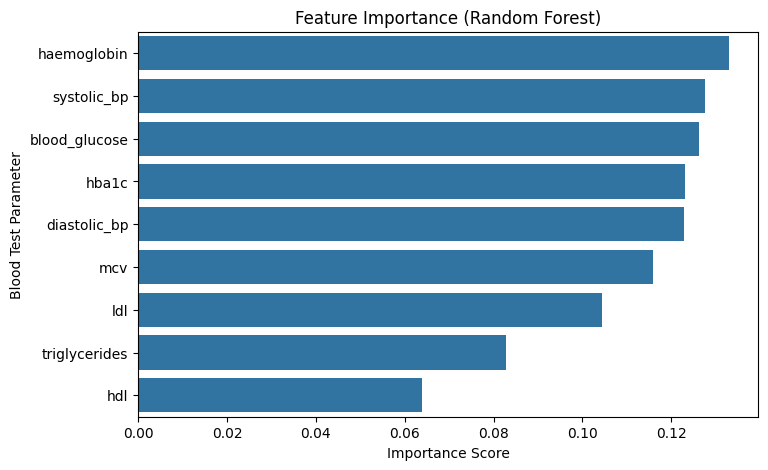


🎯 Model and encoder saved successfully.


In [52]:
# ===== Import libraries =====
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  # for saving the model

# ===== Load your cleaned Excel file =====
file_path = "blood_tests_cleaned.xlsx"  # replace if different
df = pd.read_excel(file_path)

# ===== Inspect the dataset =====
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nClass distribution:\n", df['condition'].value_counts())

# ===== Split features and target =====
X = df.drop('condition', axis=1)
y = df['condition']

# ===== Encode target labels (Fit, Anemia, Diabetes, Hypertension) =====
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ===== Split into training and testing sets =====
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# ===== Train the Random Forest model =====
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# ===== Evaluate the model =====
y_pred = rf_model.predict(X_test)

print("\n✅ Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ===== Feature importance (which tests matter most) =====
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Blood Test Parameter")
plt.show()

# ===== Save the trained model and label encoder =====
joblib.dump(rf_model, "medexplain_random_forest.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
print("\n🎯 Model and encoder saved successfully.")


In [53]:
import joblib
model = joblib.load("medexplain_random_forest.pkl")
encoder = joblib.load("label_encoder.pkl")

# Sample input (e.g., from user form)
new_data = pd.DataFrame([{
    'blood_glucose': 100,
    'hba1c': 5.5,
    'systolic_bp': 120,
    'diastolic_bp': 80,
    'ldl': 100,
    'hdl': 50,
    'triglycerides': 100,
    'haemoglobin': 15,
    'mcv': 6
}])

prediction = model.predict(new_data)
condition = encoder.inverse_transform(prediction)
print("Predicted Condition:", condition[0])


Predicted Condition: Fit
